## Toy Regression Problem from Deep Ensemble Paper

### Dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, v2
from torch.optim import lr_scheduler
from functorch import make_functional, vmap, vjp, jvp, jacrev
import torch.nn.functional as F

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.t

### Create toy data

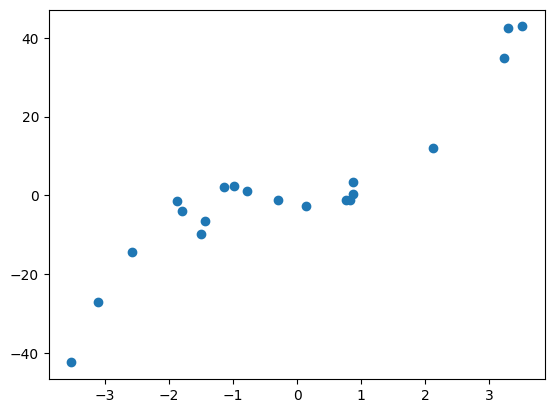

In [2]:
NUM_TRAIN_POINTS = 20
eps = np.random.normal(loc = 0, scale = 3, size = (1,NUM_TRAIN_POINTS))
training_data_x = np.random.uniform(low=-4,high=4,size = (1,NUM_TRAIN_POINTS))
# training_data_x = np.linspace(-4,4,NUM_TRAIN_POINTS)
training_data_y = np.power(training_data_x,3) + eps
# training_data_y = training_data_x + eps

train_x = training_data_x
train_y = training_data_y

training_data_y_std = training_data_y.std()
training_data_y_mean = training_data_y.mean()

# training_data_x = training_data_x - training_data_x.mean()
# training_data_x /= training_data_x.std()
# training_data_y = training_data_y - training_data_y.mean()
# training_data_y /= training_data_y.std()

plt.scatter(training_data_x,training_data_y)

NUM_TEST_POINTS = 400

test_data_x = np.linspace(-6,6,NUM_TEST_POINTS)
test_data_y = np.power(test_data_x,3)
# test_data_y = test_data_x
test_data_x_1 = 1

# test_data_x = test_data_x - test_data_x.mean()
# test_data_x /= test_data_x.std()

X_training = torch.from_numpy(training_data_x.reshape(-1,1)).float()
y = torch.from_numpy(training_data_y.reshape(-1,1)).float()
x_test = torch.from_numpy(test_data_x.reshape(-1,1)).float()
y_test = torch.from_numpy(test_data_y.reshape(-1,1)).float()

### Set up MSE Neural Network

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
INPUT_SIZE = 1
WIDTH = 100

## Single hidden layer
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, 1)
        )
        # self.linear_stack = nn.Linear(1,1)

    def forward(self, x):
        output = self.linear_relu_stack(x)
        # output = self.linear_stack(x)
        return output
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        # nn.init.normal_(m.weight,mean=0,std=1)
        nn.init.normal_(m.bias,mean=0,std=1)

## MSE Model
model = NeuralNetwork().to(device)
model.apply(weights_init)

## l2 loss with SGD optimizer using cosine annealing learning rate schedule
loss_fn = nn.MSELoss(reduction='sum')
optimizer_MSE = torch.optim.SGD(model.parameters(), momentum=0.9, lr=1e-5)
scheduler_MSE = lr_scheduler.CosineAnnealingLR(optimizer_MSE, T_max = 10, eta_min=1e-4,verbose=True)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    model.train()

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()

    for p in model.parameters():
        print(p.grad.norm())

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    print(f"loss: {loss:>7f}")

train_MSE = True
if train_MSE:
    epochs = 10000
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(X_training, y, model, loss_fn, optimizer_MSE, scheduler_MSE)
    print("Done!")

Using cpu device
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 1
-------------------------------
tensor(1363.3627)
tensor(223.6316)
tensor(1500.4470)
tensor(90.3881)
Adjusting learning rate of group 0 to 1.2202e-05.
loss: 8094.511230
Epoch 2
-------------------------------
tensor(1358.5349)
tensor(222.2868)
tensor(1490.5916)
tensor(88.5374)
Adjusting learning rate of group 0 to 1.8594e-05.
loss: 8052.939453
Epoch 3
-------------------------------
tensor(1348.1661)
tensor(219.1350)
tensor(1469.2301)
tensor(84.2903)
Adjusting learning rate of group 0 to 2.8550e-05.
loss: 7957.653320
Epoch 4
-------------------------------
tensor(1331.7484)
tensor(214.4434)
tensor(1429.6024)
tensor(75.2397)
Adjusting learning rate of group 0 to 4.1094e-05.
loss: 7755.307129
Epoch 5
-------------------------------
tensor(1324.6500)
tensor(209.8935)
tensor(1377.4503)
tensor(58.2238)
Adjusting learning rate of group 0 to 5.5000e-05.
loss: 7376.029297
Epoch 6
-------------------------------
tensor(1

### Pytorch code to compute eNTK - unused at the moment

In [5]:
# ## Code to find eNTK
# fnet, params = make_functional(model)

# def fnet_single(params, x):
#     return fnet(params, x.unsqueeze(0)).squeeze(0)

# def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
#     # Compute J(x1)
#     jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
#     jac1 = [j.flatten(2) for j in jac1]
    
#     # Compute J(x2)
#     jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
#     jac2 = [j.flatten(2) for j in jac2]
    
#     # Compute J(x1) @ J(x2).T
#     result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
#     result = result.sum(0)
#     return result

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


### Manual code to compute eNTK - definitions

In [4]:
## Find NTK
def flatten_extend_gradient(parameters):
    flat_list = []
    for parameter in parameters:
        flat_list.extend(parameter.grad.detach().numpy().flatten())
    return flat_list

def gradient_model(model,xi):
    ## model needs to have parameters with requires_grad=true
    optimizer_MSE.zero_grad()
    model(xi).backward()
    grad_vec = np.array(flatten_extend_gradient(list(model.parameters())))
    return grad_vec

def ntk_single(x1,x2,model):
    j1 = gradient_model(model,x1)
    j2 = gradient_model(model,x2)
    return j1 @ j2.transpose()

def ntk_matrix(X1,X2,model):
# Xi must be a torch variable
    Kappa = np.empty((X1.numpy().flatten().size,X2.numpy().flatten().size))
    for i1,x1 in enumerate(X1):
        for i2,x2 in enumerate(X2):
            Kappa[i1,i2] = ntk_single(x1,x2,model)
    return Kappa


## For pseudo method
def compute_J_X(X,model):
    p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n = X.numpy().flatten().size
    J_X = np.empty((n,p))
    for i,x in enumerate(X):
        J_X[i,:] = gradient_model(model,x)
    return J_X


### Manual code to compute eNTK - Computation

In [5]:
np.set_printoptions(suppress=False)

## Create UQ estimate
uq_array_full_rank = np.empty((1,NUM_TEST_POINTS))
uq_array_pseudo = np.empty((1,NUM_TEST_POINTS))

epsilon = 9

J_X = compute_J_X(X_training,model)
J_X_pseudo = np.linalg.pinv(J_X,rcond=1e-15)
J_X_matrix = J_X_pseudo @ J_X

Kappa = ntk_matrix(X_training,X_training,model)
Kappa = Kappa + epsilon*np.eye(NUM_TRAIN_POINTS)
x_array = np.random.random((1,NUM_TRAIN_POINTS))
print("condition number of Kappa = {}".format(np.linalg.cond(Kappa)))
print("Eigenvalues of Kappa_XX are {}".format(np.linalg.eigvals(Kappa)))
# print(np.linalg.eig(Kappa)[1])
# print("x @ Kappa_XX @ x^T = {}".format(x_array @ Kappa @ x_array.transpose()))

compute_uq_array = True

if compute_uq_array:
    for i,x_single in enumerate(x_test):
        x_single = x_single.reshape((1,1))
        
        kappa_xx = ntk_matrix(x_single, x_single,model)
        # print(kappa_xx)
        kappa_xX = ntk_matrix(x_single, X_training,model)

        x_solve = np.linalg.solve(Kappa,kappa_xX.transpose())
        resid_error = np.linalg.norm(Kappa @ x_solve  - kappa_xX.transpose()) / np.linalg.norm(kappa_xX.transpose())

        uq_full_rank = kappa_xx - kappa_xX @ np.linalg.solve(Kappa,kappa_xX.transpose())

        grad_f_x = gradient_model(model,x_single)
        uq_pseudo = np.inner(grad_f_x,grad_f_x) - grad_f_x.transpose() @ J_X_matrix @ grad_f_x

        uq_array_full_rank[0,i] = uq_full_rank
        uq_array_pseudo[0,i] = uq_pseudo

        # print("x_test = {}, uncertainty estimate is {}, kappa_xx is {}, mult is {}".format(x_single.squeeze(0).squeeze(0),uq.squeeze(0).squeeze(0), kappa_xx.squeeze(0).squeeze(0), (kappa_xX @ np.linalg.solve(Kappa,kappa_xX.transpose())).squeeze(0).squeeze(0)))
        # print("condition number of Kappa = {}".format(np.linalg.cond(Kappa)))
        # print("Residual error from solve = {}  \n".format(resid_error))

print("Number of zero values for full rank: {}".format(uq_array_full_rank[uq_array_full_rank==0].size))
print("Number of negative values for full rank: {}".format(uq_array_full_rank[uq_array_full_rank<0].size))
print("Number of zero values for pseudo: {}".format(uq_array_pseudo[uq_array_pseudo==0].size))
print("Number of negative values for pseudo: {}".format(uq_array_pseudo[uq_array_pseudo<0].size))
if uq_array_pseudo[uq_array_pseudo<0].size != 0: uq_array_pseudo[uq_array_pseudo<0]=0

condition number of Kappa = 2110.7344005681593
Eigenvalues of Kappa_XX are [1.89965056e+04 1.01175897e+04 2.77784231e+03 4.19777153e+02
 3.31661086e+02 1.34401578e+02 8.33787849e+01 3.86961773e+01
 3.43441672e+01 2.51028072e+01 1.90210694e+01 1.57609451e+01
 1.27445493e+01 1.01976267e+01 9.10190596e+00 9.06438734e+00
 9.02682053e+00 9.01375271e+00 8.99995073e+00 9.00008923e+00]
Number of zero values for full rank: 0
Number of negative values for full rank: 0
Number of zero values for pseudo: 0
Number of negative values for pseudo: 87


### Set up Deep Ensemble Neural Network

In [39]:
## Deep Ensemble
def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(INPUT_SIZE,WIDTH)
        self.relu = nn.ReLU()
        self.linear_mu = nn.Linear(WIDTH,1)
        self.linear_sig = nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = F.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

def train_ensemble(X, y, model, loss_fn, optimizer, scheduler):
    model.train()

    # Compute prediction error
    mean, variance = model(X)
    loss = loss_fn(y, mean, variance)

    # Backpropagation
    loss.backward()

    for p in model.parameters():
        print(p.grad.norm())

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    print(f"loss: {loss:>7f}")

M = 5
learning_rate = 0.01
epochs = 4000
model_list = []
opt_list = []
sched_list = []

for i in range(M):
    model_list.append(EnsembleNetwork().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = learning_rate))
    sched_list.append(lr_scheduler.PolynomialLR(opt_list[i], epochs, 0.5, verbose=True))


print("Model is {}".format(model_list[0](X_training[1])))

NLL = CustomNLL()

TRAIN_ENSEMBLES = True
if TRAIN_ENSEMBLES:
    for i in range(M):
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_ensemble(X_training, y, model_list[i], NLL, opt_list[i], sched_list[i])
            # train_ensemble(X_training, y, model_list[i], NLL, opt_list[i])
        print("Done!")

mu_test_list = np.empty((M,NUM_TEST_POINTS))
sigma_test_list = np.empty((M,NUM_TEST_POINTS))
for i in range(M):
    mu, sig = model_list[i](x_test)
    mu_test_list[i,:] = np.reshape(to_np(mu), (NUM_TEST_POINTS))
    sigma_test_list[i,:] = np.reshape(to_np(sig),(NUM_TEST_POINTS))
mu_mean = np.mean(mu_test_list,axis=0)
sigma_mean = np.mean(sigma_test_list, axis=0) + np.mean(np.square(mu_test_list), axis = 0) - np.square(mu_mean)

NameError: name 'lr_scheduler' is not defined

### Plot figures

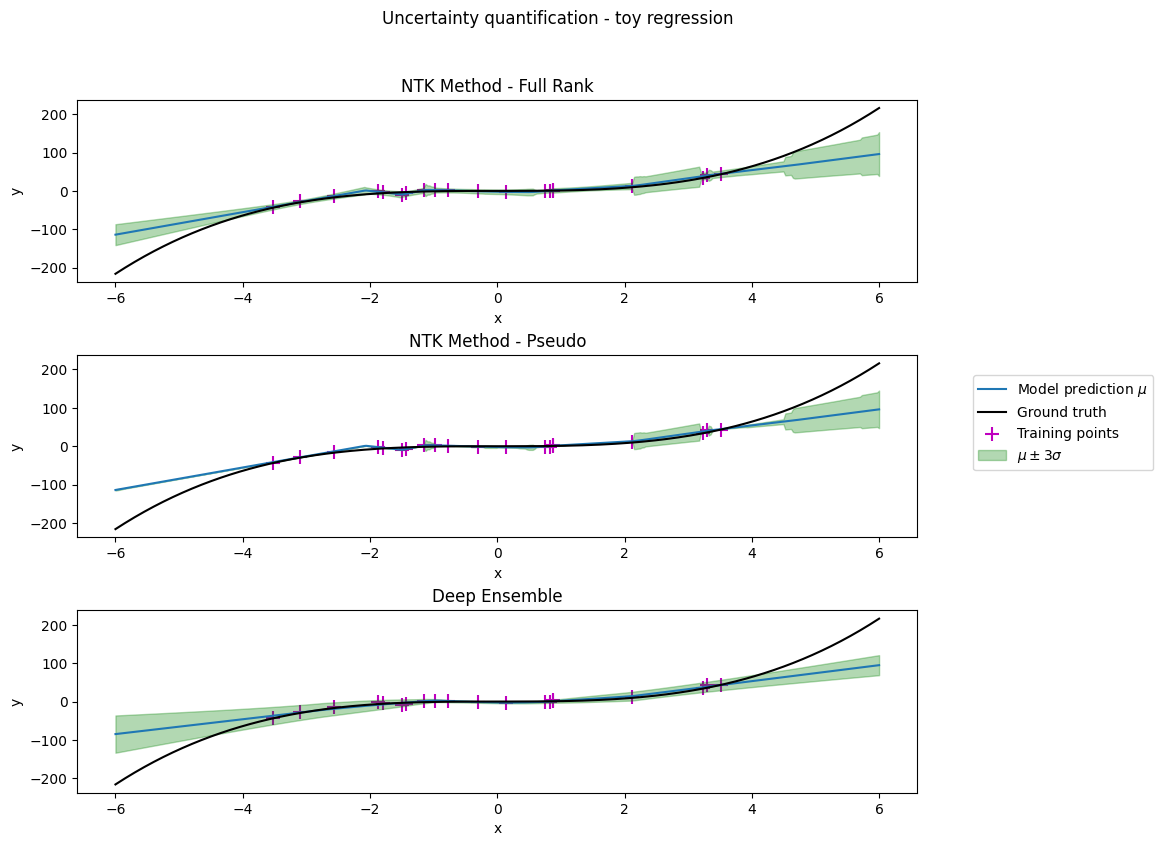

In [16]:
## Plot
f, (ax1,ax2,ax3) = plt.subplots(3,1)

f.set_figheight(9)
f.set_figwidth(12)
f.subplots_adjust(left=0.1, right=0.8, hspace=0.4)

test_data_y = model(x_test)
line1 = ax1.plot(x_test,test_data_y.detach().numpy(), markersize=12, label = "Model prediction")
line2 = ax1.plot(x_test,y_test,'k', label = "Ground truth")
line3 = ax1.scatter(train_x,train_y, s=100, c='m', marker='+', label = "Training points")
ci = np.sqrt(uq_array_full_rank)*3
y1 = test_data_y.detach().numpy()-ci.transpose()
y2 = test_data_y.detach().numpy()+ci.transpose()
# ax1.legend()
ax1.fill_between(x_test.detach().numpy().squeeze(1), y1.squeeze(1), y2.squeeze(1) , color='g', alpha=.3)
ax1.set_title("NTK Method - Full Rank")
ax1.set_xlabel('x')
ax1.set_ylabel('y')

test_data_y = model(x_test)
line1 = ax2.plot(x_test,test_data_y.detach().numpy(), markersize=12, label = "Model prediction")
line2 = ax2.plot(x_test,y_test,'k', label = "Ground truth")
line3 = ax2.scatter(train_x,train_y, s=100, c='m', marker='+', label = "Training points")
ci = np.sqrt(uq_array_pseudo)*3
y1 = test_data_y.detach().numpy()-ci.transpose()
y2 = test_data_y.detach().numpy()+ci.transpose()
# ax1.legend()
ax2.fill_between(x_test.detach().numpy().squeeze(1), y1.squeeze(1), y2.squeeze(1) , color='g', alpha=.3)
ax2.set_title("NTK Method - Pseudo")
ax2.set_xlabel('x')
ax2.set_ylabel('y')


# test_data_y = model(x_test) * training_data_y_std + training_data_y_mean
# print(test_data_y)
ax3.plot(x_test,mu_mean,markersize=12, label="Model prediction $\mu$")
ax3.plot(x_test,y_test, 'k',label="Ground truth")
ax3.scatter(train_x,train_y,s=100, c='m',marker='+',label="Training points")
ci = np.sqrt(sigma_mean)*3
y1 = mu_mean-ci
y2 = mu_mean+ci
ax3.fill_between(x_test.detach().numpy().squeeze(1), y1, y2 , color='g', alpha=.3, label='$\mu\pm3\sigma$')
ax3.set_title("Deep Ensemble")
f.legend(*ax3.get_legend_handles_labels(),loc='right')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
f.suptitle("Uncertainty quantification - toy regression")

plt.savefig("./Plots/ToyRegression/UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Regression Code
:: Outputs test error and calibration curve

In [2]:
### --- Dependencies --- ###
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
from datetime import datetime
import os
import solvers
from scipy.sparse.linalg import LinearOperator

### --- INPUT DATA HERE AS WELL AS DATASET NAME --- ###

CSV = True
dataset_str = "Energy"
num_features = 8

if CSV:
    df = pd.read_excel('.\data\Energy\ENB2012_data.xlsx')
else:
    data = np.loadtxt(fname='./data/Kin8mn/data.txt')
    df = pd.DataFrame(data)

# print(data.shape)
print("--- Loading dataset {} --- \n".format(dataset_str))
print("Number of data points = {}".format(len(df)))
print("Number of coloumns = {}".format(len(df.columns)))
print("Number of features = {}".format(num_features))

### --- --- ###

--- Loading dataset Energy --- 

Number of data points = 768
Number of coloumns = 10
Number of features = 8


training set has shape (691, 10) 

test set has shape (77, 10)

 Sample training point 
 X: [ 0.535 -0.677 -0.006 -0.657  0.996  1.366 -1.012 -1.144], 
 y: 0.018788065662671754 

Sample test point 
 X: [-1.368  1.558  1.12   0.977 -1.004  0.475  1.225  1.432], 
 y: 16.48 

 Using cpu device
Number of parameters in model = 1501

 Epoch 1 of 400
train loss for batch 1 is 1.9877854181039658
train loss for batch 2 is 36.329382954748944
train loss for batch 3 is 4.42130997379035
train loss for batch 4 is 12.511991351046527
train loss for batch 5 is 7.732662048363449
train loss for batch 6 is 7.509830119249516
train loss for batch 7 is 5.854897900428676
--- RMSE = 11.56 ---

 Epoch 2 of 400
train loss for batch 1 is 1.2867170025564536
train loss for batch 2 is 1.275097857116763
train loss for batch 3 is 2.953477641419356
train loss for batch 4 is 1.8860187879132277
train loss for batch 5 is 1.4691375467615984
train loss for batch 6 is 1.8168274177010793
train loss for batch 7 is 1.6449679063

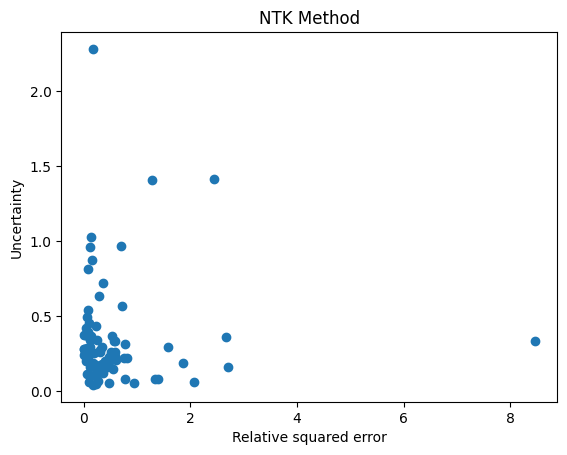

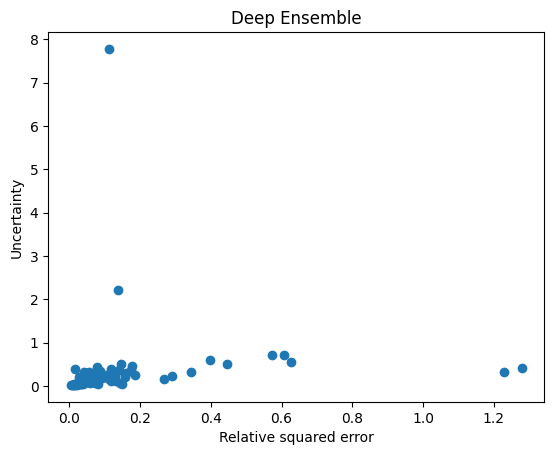

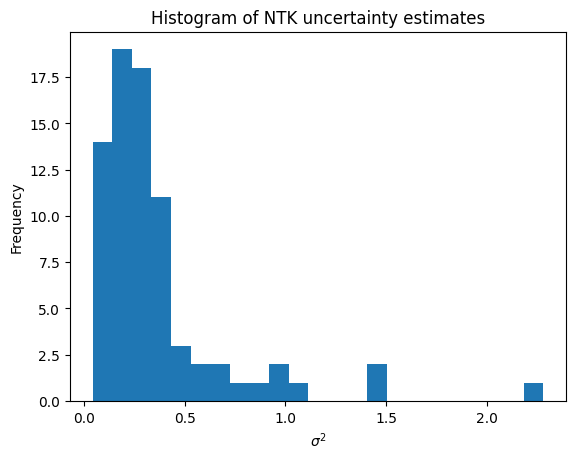

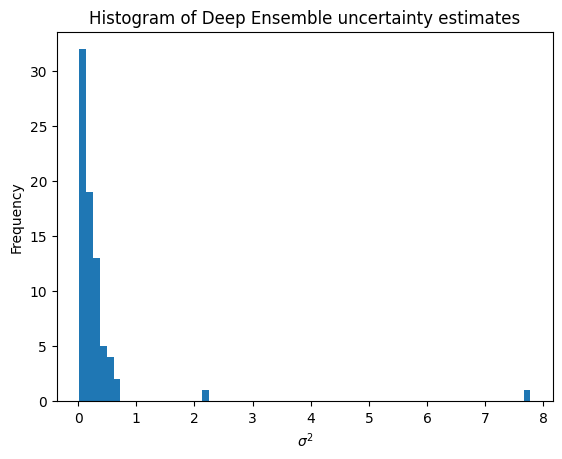

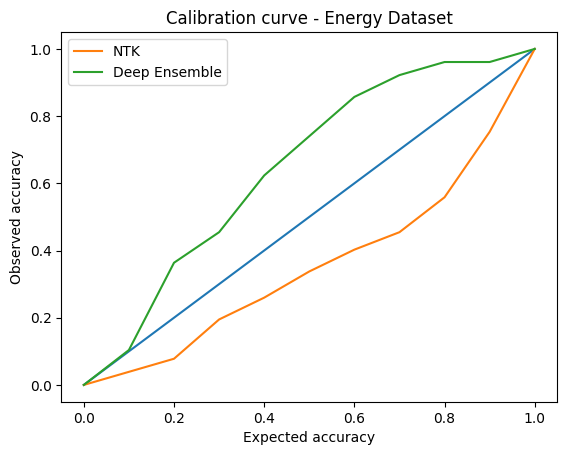


 --- RESULTS --- 

NTK RMSE = 0.76
Deep Ensemble RMSE: mean = 0.38, std = 0.03
Deep Ensemble NLL: mean = 0.43, std 0.12


In [5]:
### --- Setup dataset --- ###
class RegressionDataset(Dataset):
    '''
  Prepare dataset for regression.
  Input the number of features.

  Input:
   - dataset: numpy array

   Returns:
    - Tuple (X,y) - X is a numpy array, y is a double value.
  '''
    def __init__(self, dataset, input_dim, mX=0, sX=1, my=0, sy=1):
        self.X, self.y = dataset[:,:input_dim], dataset[:,input_dim]
        self.X, self.y = (self.X - mX)/sX, (self.y - my)/sy
        self.len_data = self.X.shape[0]

    def __len__(self):
        return self.len_data

    def __getitem__(self, i):
        return self.X[i,:], self.y[i]

TRAIN_RATIO = 0.9
BATCH_SIZE = 100
NORMALIZE_X = True
NORMALIZE_Y = True

## Num of points and dimension of data
num_points = len(df)
dimension = len(df.columns)-1

train_size = int(num_points*TRAIN_RATIO)
test_size = num_points - train_size
dataset_numpy = df.values
np.random.shuffle(dataset_numpy)
training_set, test_set = dataset_numpy[:train_size,:], dataset_numpy[train_size:,:]
print("training set has shape {} \n".format(training_set.shape))
print("test set has shape {}".format(test_set.shape))

if NORMALIZE_X:
    train_mX = training_set[:,:num_features].mean(axis=0)
    train_sX = training_set[:,:num_features].std(axis=0)
    train_sX[train_sX==0]=1
else:
    train_mX = 0
    train_sX = 1

if NORMALIZE_Y:
    train_my = training_set[:,num_features].mean(axis=0)
    train_sy = training_set[:,num_features].std(axis=0)
    if train_sy==0:
        train_sy=1
else:
    train_my = 0
    train_sy = 1

train_dataset = RegressionDataset(training_set, input_dim=num_features, mX=train_mX, sX=train_sX, my=train_my, sy=train_sy)
test_dataset = RegressionDataset(test_set, input_dim=num_features, mX=train_mX, sX=train_sX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

np.set_printoptions(suppress=True, precision=3)
print("\n Sample training point \n X: {}, \n y: {} \n".format(train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]))
print("Sample test point \n X: {}, \n y: {} ".format(test_dataset.__getitem__(0)[0], test_dataset.__getitem__(0)[1]))


### --- Setup NTK Neural Network --- ###

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"\n Using {device} device")

INPUT_DIM = 8
LAYER_WIDTH = 150
  
class NeuralNetwork(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(INPUT_DIM, LAYER_WIDTH),
      nn.ReLU(),
      nn.Linear(LAYER_WIDTH, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)
  
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        # nn.init.normal_(m.weight,mean=0,std=1)
        nn.init.normal_(m.bias,mean=0,std=1)

## MSE Model
model = NeuralNetwork().to(device=device, dtype=torch.float64)
model.apply(weights_init)
print("Number of parameters in model = {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))


### --- Train NTK Neural Network --- ###

NTK_LR = 1e-1

mse_loss = nn.MSELoss(reduction='mean')
adam_optimizer = torch.optim.Adam(model.parameters(), lr=NTK_LR)

def initial_eval(trainloader,testloader,model,loss_function,my,sy):
    for i, (X,y) in enumerate(trainloader):
        y = y.reshape((y.shape[0],1))
        if i==0:
            print("X has shape {}".format(X.shape))
            print("y has shape {}".format(y.shape))
        pred = model(X)
        loss = loss_function(pred,y)
        print("Initial train loss for batch {} is {}".format(i+1, loss))
    for i, (X,y) in enumerate(testloader):
        y = y.reshape((y.shape[0],1))
        if i==0:
            print("X has shape {}".format(X.shape))
            print("y has shape {}".format(y.shape))
        pred = model(X)
        pred = pred*sy + my
        loss = loss_function(pred,y)
        print("Initial test loss for batch {} is {}".format(i+1, loss))

def training_loop(dataloader, model, optimizer, loss_function, verbose=False):
    model.train()
    error = []
    train_loss_total = 0
    for i, (X,y) in enumerate(dataloader):
        
        # Get and prepare inputs
        y = y.reshape((y.shape[0],1))

        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        pred = model(X)
        
        # Compute loss
        loss = loss_function(pred, y)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        train_loss = loss.item()
        error.append(torch.square(y-pred))
        train_loss_total += train_loss
        # Print statistics
        if verbose:
            print("train loss for batch {} is {}".format(i+1, train_loss))

    # train_loss /= num_batches
    # print("Average train loss is {}".format(train_loss))
    train_loss_mean = train_loss_total / i
    return error, train_loss_mean

def test_loop(dataloader, model, my, sy, loss_function):
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y = y.reshape((y.shape[0],1))
            pred = model(X)
            pred = pred * sy + my
            test_loss = (loss_function(pred, y).item())**0.5
            rel_error = torch.square(y-pred)
            print("--- RMSE = {:.2f} ---".format(test_loss))
    return test_loss, rel_error

TRAINING_RUN = True
INITIAL_EVAL = False
NTK_EPOCHS = 400

if INITIAL_EVAL:
    initial_eval(train_loader, test_loader, model=model, loss_function=mse_loss, my=train_my, sy=train_sy)

if TRAINING_RUN:
    # Run the training loop
    for epoch in range(NTK_EPOCHS):
        print("\n Epoch {} of {}".format(epoch+1, NTK_EPOCHS))
        final_ntk_error, train_loss_mean  = training_loop(train_loader, model, optimizer=adam_optimizer, loss_function=mse_loss,verbose=True)
        final_ntk_RMSE, final_ntk_rel_error = test_loop(test_loader, model, my=train_my, sy=train_sy, loss_function=mse_loss)
    # Process is complete.
    print('\n Training process has finished.')
    print("Final training MSE = {:.3f}".format(train_loss_mean))
    print("Final test RMSE = {:.2f}".format(final_ntk_RMSE))



### --- Compute uncertainty estimate - NTK --- ###
    
## Find NTK
def flatten_extend_gradient(parameters):
    flat_list = []
    for parameter in parameters:
        flat_list.extend(parameter.grad.detach().numpy().flatten())
    return flat_list

def gradient_model(model,optimizer,xi):
    ## model needs to have parameters with requires_grad=true
    optimizer.zero_grad()
    model(xi).backward()
    grad_vec = np.array(flatten_extend_gradient(list(model.parameters())))
    return grad_vec

def ntk_single(x1,x2,model):
    j1 = gradient_model(model=model,optimizer=adam_optimizer,xi=x1)
    j2 = gradient_model(model=model,optimizer=adam_optimizer,xi=x2)
    return j1 @ j2.transpose()

def ntk_matrix(X1,X2,model):
    # Xi must be a torch variable
    Kappa = np.empty((len(X1),len(X2)))
    for i1,x1 in enumerate(X1):
        if len(X1)>1 and len(X2)>1:
            if i1==0:
                start = time.time()
                end = 0
            if i1==1:
                end = time.time()
                it_time = end-start
                print("Time left = {:.1f}s".format(it_time*(len(X1)-(i1+1))))
            if i1 % 10 == 0 and i1 > 0:
                print("Computing rows: {:.2f}%".format(100*(i1+1)/len(X1)))
                print("Time left = {:.1f}s".format(it_time*(len(X1)-(i1+1))))
        if type(x1) is tuple:
            x1,_ = x1
        x1 = torch.from_numpy(x1)
        for i2,x2 in enumerate(X2):
            if type(x2) is tuple:
                x2,_ = x2
            x2 = torch.from_numpy(x2)
            Kappa[i1,i2] = ntk_single(x1,x2,model)
    return Kappa

def MVP_JTX(v,model,X_training):
    p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    mvp = np.zeros((p,1))
    for i,(xi,_) in enumerate(X_training):
        xi = torch.from_numpy(xi)
        g = gradient_model(model=model,optimizer=adam_optimizer,xi=xi).reshape((p,1))
        mvp += v[i]*g
    return mvp

def MVP_JX(v,model,X_training):
    p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n = len(train_dataset)
    mvp = np.zeros((n,1))
    v = v.reshape((p,1))
    for i,(xi,_) in enumerate(X_training):
        xi = torch.from_numpy(xi)
        g = gradient_model(model=model,optimizer=adam_optimizer,xi=xi).reshape((p,1))
        mvp[i,0] = g.transpose() @ v
    return mvp

def MVP_JJT(v,model,X_training):
    x1 = MVP_JTX(v,model,X_training)
    x2 = MVP_JX(x1,model,X_training)
    return x2

np.set_printoptions(suppress=False, precision=3)

FIND_KAPPA = False
REPORT_KAPPA = False
FIND_UNCERTAINTY = False
FIND_UNCERTAINTY_ITERATIVE = True

if FIND_UNCERTAINTY_ITERATIVE:
    mvp = lambda v : MVP_JJT(v=v,model=model,X_training=train_dataset)
    A = LinearOperator((len(train_dataset),len(train_dataset)), matvec=mvp)
    print("\n --- Finding uncertainty estimates --- \n")
    uncertainty_array = np.empty((1,len(test_dataset)))
    for i,(x,_) in enumerate(test_dataset):
        if i==0:
            start = time.time()
            end = 0
        if i==1:
            end = time.time()
            it_time = end-start
            print("Time left = {:.1f}s".format(it_time*(len(test_dataset)-(i+1))))
            
        if i % 10 == 0 and i > 0:
            print("Finding values: {:.2f}%".format(100*(i+1)/len(test_dataset)))
            print("Time left = {:.1f}s".format(it_time*(len(test_dataset)-(i+1))))
        x = x.reshape((1,8))
        
        kappa_xx = ntk_matrix(x, x, model)
        kappa_xX = ntk_matrix(train_dataset, x, model)
        b = kappa_xX

        if i==0:
            init = False
            x0 = 0
        else:
            init = True
            x0 = x_solve

        x_solve = solvers.CR(A,b,rtol=1e-9,init=False, x0=0, maxit=100, VERBOSE=False)


        uncertainty_estimate = kappa_xx - b.transpose() @ x_solve

        uncertainty_array[0,i] = uncertainty_estimate
    
    print("Finished! \n")
    print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
    print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))


if FIND_KAPPA:
    ntk_error = torch.cat(final_ntk_error).detach().numpy()
    std_ntk_error = np.std(ntk_error-np.mean(ntk_error))
    print(std_ntk_error**2)
    EPSILON = std_ntk_error**2
    EPSILON = 0
    if not NORMALIZE_X and not NORMALIZE_Y:
        EPSILON = max(std_ntk_error**2,10)
    print("\n --- Finding Kappa --- \n")
    Kappa = ntk_matrix(train_dataset,train_dataset,model)
    Kappa = Kappa + EPSILON*np.eye(len(train_dataset))

if REPORT_KAPPA:
    x_array = np.random.random((1,len(train_dataset)))
    print("\n--- Kappa Summary --- \n")
    print("Regularising constant = {}".format(EPSILON))
    print("Condition number of Kappa = {:.2f}".format(np.linalg.cond(Kappa)))
    eigvals = np.linalg.eigvals(Kappa)
    print("Number of negative eigenvalues of Kappa = {}".format(eigvals[eigvals<0].size))
    print("Number of zero eigenvalues of Kappa = {}".format(eigvals[eigvals==0].size))
    print("Smallest eigenvalue is = {}".format(sorted(eigvals)[0]))

if FIND_UNCERTAINTY:
    print("\n --- Finding uncertainty estimates --- \n")
    uncertainty_array = np.empty((1,len(test_dataset)))
    for i,(x,_) in enumerate(test_dataset):
        if i==0:
            start = time.time()
            end = 0
        if i==1:
            end = time.time()
            it_time = end-start
            print("Time left = {:.1f}s".format(it_time*(len(test_dataset)-(i+1))))
            
        if i % 10 == 0 and i > 0:
            print("Finding values: {:.2f}%".format(100*(i+1)/len(test_dataset)))
            print("Time left = {:.1f}s".format(it_time*(len(test_dataset)-(i+1))))
        x = x.reshape((1,8))
        
        kappa_xx = ntk_matrix(x, x, model)
        kappa_xX = ntk_matrix(x, train_dataset, model)

        x_solve = np.linalg.solve(Kappa, kappa_xX.transpose())
        resid_error = np.linalg.norm(Kappa @ x_solve  - kappa_xX.transpose()) / np.linalg.norm(kappa_xX.transpose())

        uncertainty_estimate = kappa_xx - kappa_xX @ np.linalg.solve(Kappa,kappa_xX.transpose())

        uncertainty_array[0,i] = uncertainty_estimate
    
    print("Finished! \n")
    print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
    print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))

### --- Setup, train and find uncertainty estimate for Deep Ensemble --- ###

def to_np(x):
    return x.cpu().detach().numpy()

INPUT_DIM = 8
LAYER_WIDTH = 50

class EnsembleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(INPUT_DIM,LAYER_WIDTH)
        self.relu = nn.ReLU()
        self.linear_mu = nn.Linear(LAYER_WIDTH,1)
        self.linear_sig = nn.Linear(LAYER_WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = F.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

def training_loop(dataloader, model, optimizer, loss_function, verbose=False):
    model.train()
    for i, (X,y) in enumerate(dataloader):
        
        # Get and prepare inputs
        y = y.reshape((y.shape[0],1))
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        mean, variance = model(X)
        
        # Compute loss
        loss = loss_function(y, mean, variance)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        train_loss = loss.item()

        # Print statistics
        if verbose:
            print("train loss for batch {} is {}".format(i+1, train_loss))

    # train_loss /= num_batches
    # print("Average train loss is {}".format(train_loss))

def test_loop(dataloader, model, my, sy, loss_function):
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y = y.reshape((y.shape[0],1))
            mean, variance = model(X)
            mean = mean * sy + my
            variance = variance * (sy**2)
            test_loss = loss_function(y, mean, variance)
            rel_error = torch.square(y-mean)
            print("--- Test NLL = {:.2f} ---".format(test_loss))
    MSE = mse_loss(y,mean).item()
    RMSE = MSE**0.5
    return RMSE, test_loss, rel_error

M = 5
ensemble_learning_rate = 1e-2
ENSEMBLE_EPOCHS = 1000

model_list = []
opt_list = []
RMSE_list = np.empty(M)
NLL_list = np.empty(M)
Ensemble_rel_error_arr = np.empty((M,test_size))

for i in range(M):
    model_list.append(EnsembleNetwork().to(device=device,dtype=torch.float64))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = ensemble_learning_rate))

NLL = CustomNLL()

TRAIN_ENSEMBLES = True
if TRAIN_ENSEMBLES:
    for i in range(M):
        for t in range(ENSEMBLE_EPOCHS):
            print(f"Epoch {t+1}\n-------------------------------")
            training_loop(dataloader=train_loader, model=model_list[i], optimizer=opt_list[i], loss_function=NLL, verbose=False)
            Ensemble_final_RMSE, Ensemble_final_NLL, Ensemble_rel_error = test_loop(test_loader, model=model_list[i], my=train_my, sy=train_sy, loss_function=NLL)
            RMSE_list[i] = Ensemble_final_RMSE
            NLL_list[i] = Ensemble_final_NLL
            Ensemble_rel_error_arr[i,:] = Ensemble_rel_error.detach().numpy().squeeze(1)
            # train_ensemble(X_training, y, model_list[i], NLL, opt_list[i])
        print("Done!")

print(RMSE_list)
print(NLL_list)

mu_test_list = np.empty((M,test_size))
sigma_test_list = np.empty((M,test_size))
for i in range(M):
    for X,y in test_loader:
        y = y.reshape((y.shape[0],1))
        mu, sig = model_list[i](X)
        mu = mu * train_sy + train_my
        sig = sig * (train_sy**2)
        mu_test_list[i,:] = np.reshape(to_np(mu), (test_size))
        sigma_test_list[i,:] = np.reshape(to_np(sig),(test_size))
mu_mean = np.mean(mu_test_list,axis=0)
sigma_mean = np.mean(sigma_test_list, axis=0) + np.mean(np.square(mu_test_list), axis = 0) - np.square(mu_mean)
Ensemble_rel_error_mean = np.mean(Ensemble_rel_error_arr,axis=0)

### --- Plot results --- ###
print("\n --- Plotting Results --- \n")

if NORMALIZE_X and NORMALIZE_Y:
    plot_dir = "./Plots/{}/Norm/".format(dataset_str)
elif NORMALIZE_X and not NORMALIZE_Y:
    plot_dir = "./Plots/{}/Norm_X/".format(dataset_str)
elif not NORMALIZE_X and NORMALIZE_Y:
    plot_dir = "./Plots/{}/Norm_Y/".format(dataset_str)
else:
    plot_dir = "./Plots/{}/Un_Norm/".format(dataset_str)

if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

## NTK Scatter
plot_name = "NTK_scatter.pdf"
plt.scatter(final_ntk_rel_error, uncertainty_array*(train_sy**2))
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("NTK Method")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## Deep Ensemble scatter
plot_name = "Deep_ensemble_scatter.pdf"
plt.scatter(Ensemble_rel_error_mean, sigma_mean)
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("Deep Ensemble")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## NTK Histogram
plot_name = "NTK_hist.pdf"
plt.hist(sorted((train_sy**2)*uncertainty_array.squeeze(0)), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of NTK uncertainty estimates")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## Deep Ensemble Histogram
plot_name = "Deep_ensemble_hist.pdf"
plt.hist(sorted(sigma_mean), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of Deep Ensemble uncertainty estimates")
plt.savefig(plot_dir + plot_name.format(dataset_str), format="pdf", bbox_inches="tight")
plt.show()

### --- Plot calibration curve --- ###

def calibration_curve_ntk(testloader, uncertainties, model, num_c,my,sy):
    c = np.linspace(0,1,num_c)
    observed_true = np.empty(num_c)
    total = uncertainties.size
    for i, (X,y) in enumerate(testloader):
         Yhat_pre = model(X)
         Yhat = Yhat_pre.detach().numpy()*sy + my
         y = y.detach().numpy()
    for i,ci in enumerate(c):
        z = scipy.stats.norm.ppf((1+ci)/2)
        ci_c = z * np.sqrt(uncertainties*(sy**2))
        left_ci = y >= (Yhat - ci_c.reshape(-1,1)).squeeze(1)
        right_ci = y <= (Yhat + ci_c.reshape(-1,1)).squeeze(1)
        observed_true_c = np.logical_and(left_ci,right_ci)
        num_true = observed_true_c[observed_true_c==True].size
        observed_true[i] = num_true/total
        # print(num_true)
    return observed_true

def calibration_curve_ensemble(testloader, mu, sigma2, num_c):
    c = np.linspace(0,1,num_c)
    observed_true = np.empty(num_c)
    total = mu.size
    for i, (_,y) in enumerate(testloader):
         y = y.detach().numpy()
    for i,ci in enumerate(c):
        z = scipy.stats.norm.ppf((1+ci)/2)
        ci_c = z * np.sqrt(sigma2)
        left_ci = y >= (mu - ci_c)
        right_ci = y <= (mu + ci_c)
        observed_true_c = np.logical_and(left_ci,right_ci)
        num_true = observed_true_c[observed_true_c==True].size
        observed_true[i] = num_true/total
        # print(num_true)
    return observed_true

plot_name = "calibration_curve.pdf"
def plot_calibration(observed_true_ntk, observed_true_ensemble, dataset_str):
    num_c = observed_true_ntk.size
    c = c = np.linspace(0,1,num_c)
    plt.plot(c,c)
    plt.plot(c,observed_true_ntk, label='NTK')
    plt.plot(c,observed_true_ensemble, label='Deep Ensemble')
    plt.xlabel("Expected accuracy")
    plt.ylabel("Observed accuracy")
    plt.title("Calibration curve - {} Dataset".format(dataset_str))
    plt.legend()
    plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
    plt.show()

observed_true_ntk = calibration_curve_ntk(testloader=test_loader, uncertainties=uncertainty_array, model=model, num_c=11, my=train_my, sy=train_sy)
observed_true_ensemble = calibration_curve_ensemble(testloader=test_loader, mu=mu_mean, sigma2=sigma_mean, num_c=11)
plot_calibration(observed_true_ntk=observed_true_ntk, observed_true_ensemble=observed_true_ensemble, dataset_str=dataset_str)

results_name = "results.txt"
with open(plot_dir+results_name,'w') as results:
    results.write("--- Results --- \n")
    results.write("NTK RMSE = {:.2f} \n".format(final_ntk_RMSE))
    results.write("Deep Ensemble RMSE: mean = {:.2f}, std = {:.2f} \n".format(np.mean(RMSE_list),np.std(RMSE_list)))
    results.write("Deep Ensemble NLL: mean = {:.2f}, std {:.2f} \n".format(np.mean(NLL_list),np.std(NLL_list)))
    results.write("\n --- Training Details --- \n")
    results.write("NTK Learning Rate = {} \n".format(NTK_LR))
    results.write("NTK Epochs = {} \n".format(NTK_EPOCHS))
    results.write("Deep Ensemble Learning Rate = {} \n".format(ensemble_learning_rate))
    results.write("Deep Ensemble Epochs = {} \n".format(ENSEMBLE_EPOCHS))
    results.write("Number of ensembles = {} \n".format(M))
    if FIND_UNCERTAINTY_ITERATIVE:
        results.write("\n --- NTK Method Details --- \n")
        results.write("\n Using CR.")
        results.write("RTOL = 1e-9")
        results.write("MaxIt = 100")
    else:
        results.write("\n --- NTK Method Details --- \n")
        results.write("Regularising constant = {:.2f} \n".format(EPSILON))
        results.write("Condition number of Kappa = {:.2f} \n".format(np.linalg.cond(Kappa)))
        results.write("Number of negative eigenvalues of Kappa = {} \n".format(eigvals[eigvals<0].size))
        results.write("Number of zero eigenvalues of Kappa = {} \n".format(eigvals[eigvals==0].size))
        results.write("Number of negative values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array<0].size))
        results.write("Number of zero values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array==0].size))

print("\n --- RESULTS --- \n")
print("NTK RMSE = {:.2f}".format(final_ntk_RMSE))
print("Deep Ensemble RMSE: mean = {:.2f}, std = {:.2f}".format(np.mean(RMSE_list),np.std(RMSE_list)))
print("Deep Ensemble NLL: mean = {:.2f}, std {:.2f}".format(np.mean(NLL_list),np.std(NLL_list)))


In [3]:
uncertainty_array

array([[0.001, 0.005, 0.002, 0.003, 0.01 , 0.001, 0.006, 0.002, 0.001,
        0.002, 0.001, 0.004, 0.001, 0.013, 0.001, 0.002, 0.002, 0.013,
        0.002, 0.002, 0.007, 0.001, 0.008, 0.003, 0.001, 0.001, 0.001,
        0.004, 0.001, 0.007, 0.002, 0.004, 0.001, 0.001, 0.015, 0.001,
        0.001, 0.004, 0.001, 0.002, 0.001, 0.002, 0.001, 0.003, 0.003,
        0.02 , 0.003, 0.001, 0.01 , 0.003, 0.006, 0.001, 0.001, 0.002,
        0.003, 0.005, 0.002, 0.004, 0.018, 0.006, 0.008, 0.005, 0.015,
        0.002, 0.003, 0.007, 0.001, 0.001, 0.002, 0.024, 0.004, 0.002,
        0.001, 0.002, 0.002, 0.012, 0.   ]])